# Problem definition

SEC filings are long, filled with boilerplate language, and often difficult to parse through even as an experienced analyst. Let's assume that I have the following question:

> "What was the annual revenue for TSLA in 2024, and what was media sentiment after the SEC 10-K filings were released?"

For the sake of simplicity, let's assume the answer can be obtained with the following two sources:
- [TSLA 2024 10-K SEC filing](https://www.sec.gov/Archives/edgar/data/1318605/000162828025003063/tsla-20241231.htm#ie9fbbc0a99a6483f9fc1594c1ef72807_157), 347,000 tokens
- [Yahoo Finance article](https://finance.yahoo.com/news/tesla-inc-tsla-q4-2024-072241602.html), 5,000 tokens

To implement an architecture that could answer these questions, we have the following options. There are lots of LLM's we could use, but let's assume that we're using GPT 4o at commercial API usage rates. 

- GPT-4o with unfiltered context: Manually upload full context to GPT API. 
- GPT-4o with web search: Ask the question directly, and don't provide context.
- GPT-4o with keyword search: BM25 search to fetch top-N chunks that match query terms to article metadata, and send those chunks to the API.
- RAG with semantic search (GPT-4o): Search vector database for context, and  upload to GPT-4o

Using our article baseline, and assuming that each method can accurately answer the question, here are the daily cost extrapolations for a platform with the following levels of activity:

- We have a platform with 1000 concurrent users at any given moment
- These users use the platform for 10 hours per day
- Each user asks 1 question every 3 minutes, each similar to the above question (39 tokens).

| Scenario                           | Input Tokens | Output Tokens | Cost per Query (USD) | Total Daily Cost (USD) |
|------------------------------------|--------------|----------------|-----------------------|-------------------------|
| GPT-4o with unfiltered context     | 347,000      | 200            | $1.7390               | $347,800.00             |
| GPT-4o with web search             | 7,500        | 200            | $0.0415               | $8,300.00               |
| Keyword search + GPT-4o            | 3,000        | 200            | $0.0190               | $3,800.00               |
| RAG with semantic search (GPT-4o)  | 2,000        | 200            | $0.0140               | $2,800.00               |
| RAG with semantic search (GPT 3.5) | 2,000        | 200            | $0.0013               | $260              |

Our API costs would be 66% cheaper using a RAG compared to web search. If we optimize the semantic retrieval methodology for accuracy and use GPT 3.5 instead of 4o, it would be 97% cheaper. 

| Scenario                           | High Accuracy | Cost Efficient | Low Latency | Scalable | Curated Sources |
|------------------------------------|----------------|----------------|-------------|----------|---------------------|
| GPT-4o with unfiltered context     | ✅             | ❌             | ❌          | ❌       | ✅                  |
| GPT-4o with web search             | ✅             | ✅             | ✅          | ✅       | ❌                  |
| Keyword search + GPT-4o            | ❌             | ✅             | ✅          | ✅       | ✅                  |
| RAG with semantic search (GPT-4o)  | ✅             | ✅             | ✅          | ✅       | ✅                  |

# Evaluation Criteria

We'll implement all scenarios above, and evaluate them on the following criteria:

- Tier 1: Single-source QA accuracy. *How well does our engine answer questions about the 10-K filings?*
    - Evaluation data set: [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K)
    - Evaluation metrics:
        - ROUGE
        - Recall@k for chunk retrieval
        - NDCG@10
<!-- - Tier 2 (if time permits): Multi-source QA accuracy. *How well does our engine answer questions about the 10-K filings AND related media?*
    
    - Evaluation metrics:
        -  -->

# Datasets to use:

<!-- - **SEC 10-k filings** for the years 2020-2023 for AAPL, NVDA, TSLA, GOOGL. We'll scrape this data with the [EDGAR-CRAWLER](https://github.com/lefterisloukas/edgar-crawler) project. -->
- **Source SEC Filings**: the [financial-reports-sec](https://huggingface.co/datasets/JanosAudran/financial-reports-sec) dataset is already cleaned and separated into sections. I'll use this for simplicity; a real-life scenario would include implementing a pipeline to generate the features. 
- **Evaluation set**: QA answer responses based on the [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K) labeled dataset from HuggingFace. 


# EDA

## Textual analysis

First we'll get the structured 10K filings

In [1]:
#imports 
%load_ext autoreload
%autoreload 2
import sys, os
from pathlib import Path

# Add project root to sys.path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

sys.path.append("..")
import numpy as np
import pandas as pd
from pprint import pprint
from datasets import load_dataset


In [2]:
raw_data_path = project_root / "data" / 'raw'/ "df_filings_full.parquet"

# # Run the code below to download the data, it's about 20GB so not recommended unless you have time to kill
# ds = load_dataset("JanosAudran/financial-reports-sec", "large_full")
# # Save to parquet
# ds.save_to_disk(f"{raw_data_path}")
import duckdb

# Connect to in-memory database
con = duckdb.connect(database=':memory:')
tickers_of_interest = str(('AAPL', 'META', 'TSLA', 'NVDA', 'AMZN'))
query = f"""
SELECT 
  sentence, 
  docID, 
  CAST(RIGHT(docID, 4) AS INTEGER) AS fiscal_year,
  tickers[1] AS ticker,
  sentenceID
FROM read_parquet('{raw_data_path}')
WHERE tickers IS NOT NULL
  AND array_length(tickers) > 0
  AND tickers[1] IN {tickers_of_interest} -- minimize corpus for computational efficiency
  AND LEN(sentence) > 20 -- filter boilerplate
"""
# Read parquet file and display first 10 rows
df = con.execute(query).df()
display(df)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,sentence,docID,fiscal_year,ticker,sentenceID
0,"ITEM 1. BUSINESS Overview We design, develop, ...",0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_0
1,We generally sell our products directly to cus...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_1
2,We also continue to grow our customer-facing i...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_2
3,"We emphasize performance, attractive styling a...",0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_3
4,We also strive to lower the cost of ownership ...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_4
...,...,...,...,...,...
117799,Exhibits See the Exhibit Index immediately fol...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_6
117800,POWER OF ATTORNEY KNOW ALL PERSONS BY THESE PR...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_7
117801,Pursuant to the requirements of the Securities...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_8
117802,† Portions of exhibit have been granted confid...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_9


The data we have above is at the sentence level. 

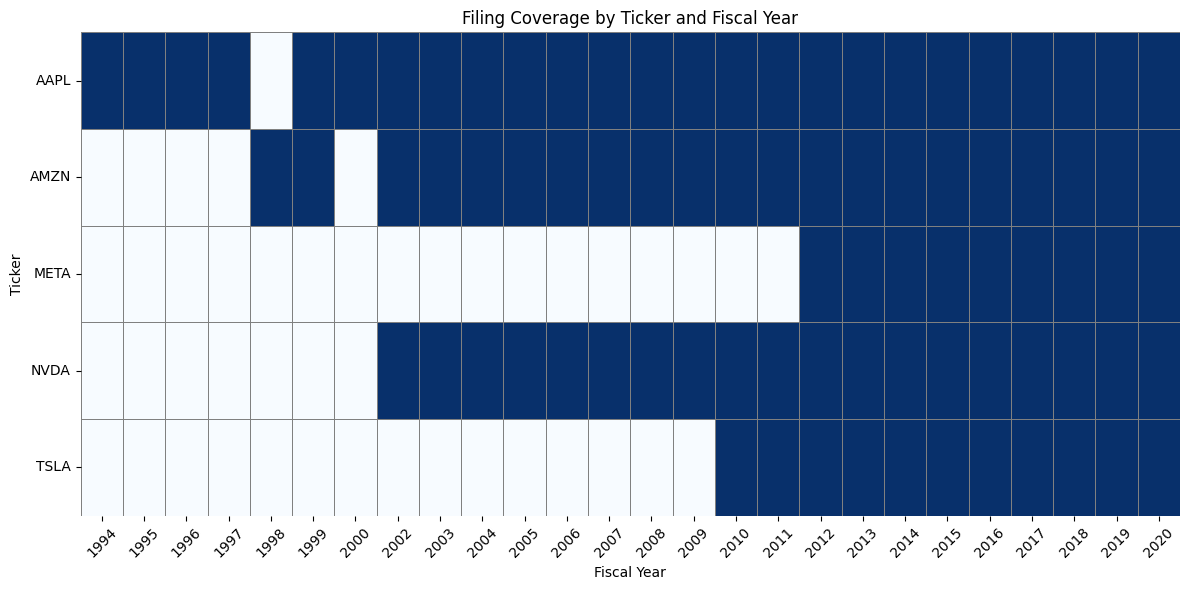

In [5]:
import sys, os
from pathlib import Path
sys.path.append(Path(os.getcwd()).parent.parent)
from sec_insights.eda.viz import plot_filing_coverage

plot_filing_coverage(df)

Looks like we only have all companies from 2012-2020, so we'll restrict our analysis to these years

In [6]:
df = df[df['fiscal_year'].between(2012, 2020)]

Let's do some textual EDA. First we'll see how many tokens we have per document, per sentence, and per section. Vastly different values could affect our chunking strategy. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


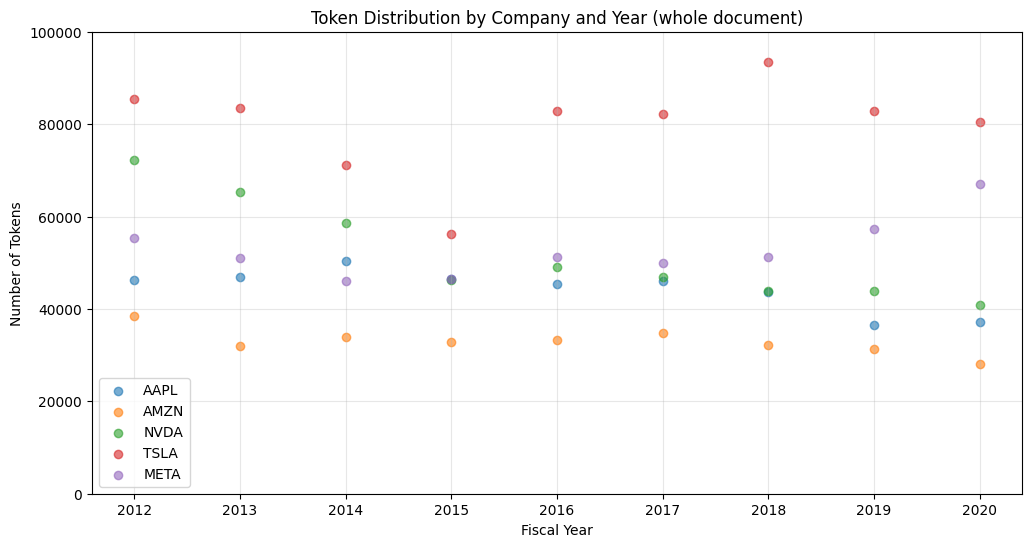

,docID,ticker,fiscal_year,full_text,num_tokens
0,0000320193_10-K_2012,AAPL,2012,Item 1. Business Company Background The Compan...,46187
1,0000320193_10-K_2013,AAPL,2013,Item 1. Business Company Background The Compan...,46989
2,0000320193_10-K_2014,AAPL,2014,Item 1. Business Company Background The Compan...,50371
3,0000320193_10-K_2015,AAPL,2015,Item 1. Business Company Background The Compan...,46542
4,0000320193_10-K_2016,AAPL,2016,Item 1. Business Company Background The Compan...,45378


In [7]:
import matplotlib.pyplot as plt
from sec_insights.eda.viz import count_tokens, plot_token_distribution
%load_ext autoreload
%autoreload 2

# Extract section components and create standardized section field
df['section_num'] = df['sentenceID'].str.extract(r'section_(\d+)')[0].astype(int)
df['section_letter'] = df['sentenceID'].str.extract(r'section_\d+([A-Z]?)')[0].fillna('')
df['section'] = df['section_num'].astype(str) + df['section_letter']
df['sentence_num'] = df['sentenceID'].str.extract(r'_(\d+)$')[0].astype(int)
df['sentence_token_count'] = df['sentence'].apply(count_tokens)

# Group by docID to get full document text
df_docs = (df.sort_values(['docID', 'section', 'sentence_num'])
          .groupby(['docID', 'ticker', 'fiscal_year'])
          .agg({'sentence': ' '.join})
          .reset_index()
          .rename(columns={'sentence': 'full_text'}))

# Count tokens in full text
df_docs['num_tokens'] = df_docs['full_text'].apply(count_tokens)

# Create scatter plot
plt.figure(figsize=(12, 6))
for ticker in df_docs['ticker'].unique():
    ticker_data = df_docs[df_docs['ticker'] == ticker]
    plt.scatter(ticker_data['fiscal_year'], 
                ticker_data['num_tokens'],
                label=ticker,
                alpha=0.6)

plt.title('Token Distribution by Company and Year (whole document)')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Tokens')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100_000)
plt.show()

df_docs.head()

TSLA has consistently longer documents. 

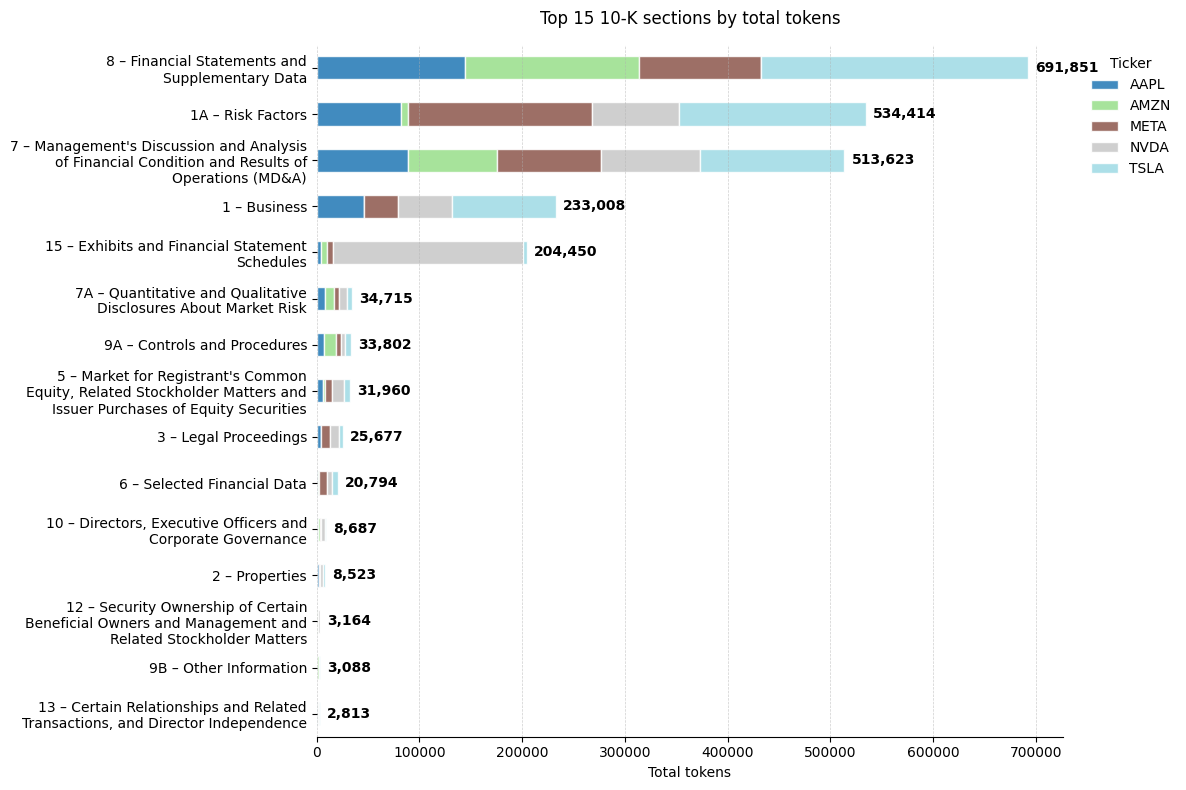

In [8]:
from src.sec_insights.eda.viz import plot_top_sections_by_tokens

# Call the function
plot_top_sections_by_tokens(df, top_n=15)

Seems there's class imbalance in the types of sections. represented. Also, interesting to see that Amazon doesn't talk too much about their risk factors, and that Nvidia has a lot of information about their financial statement schedules. Sections are not uniformly distributed. 

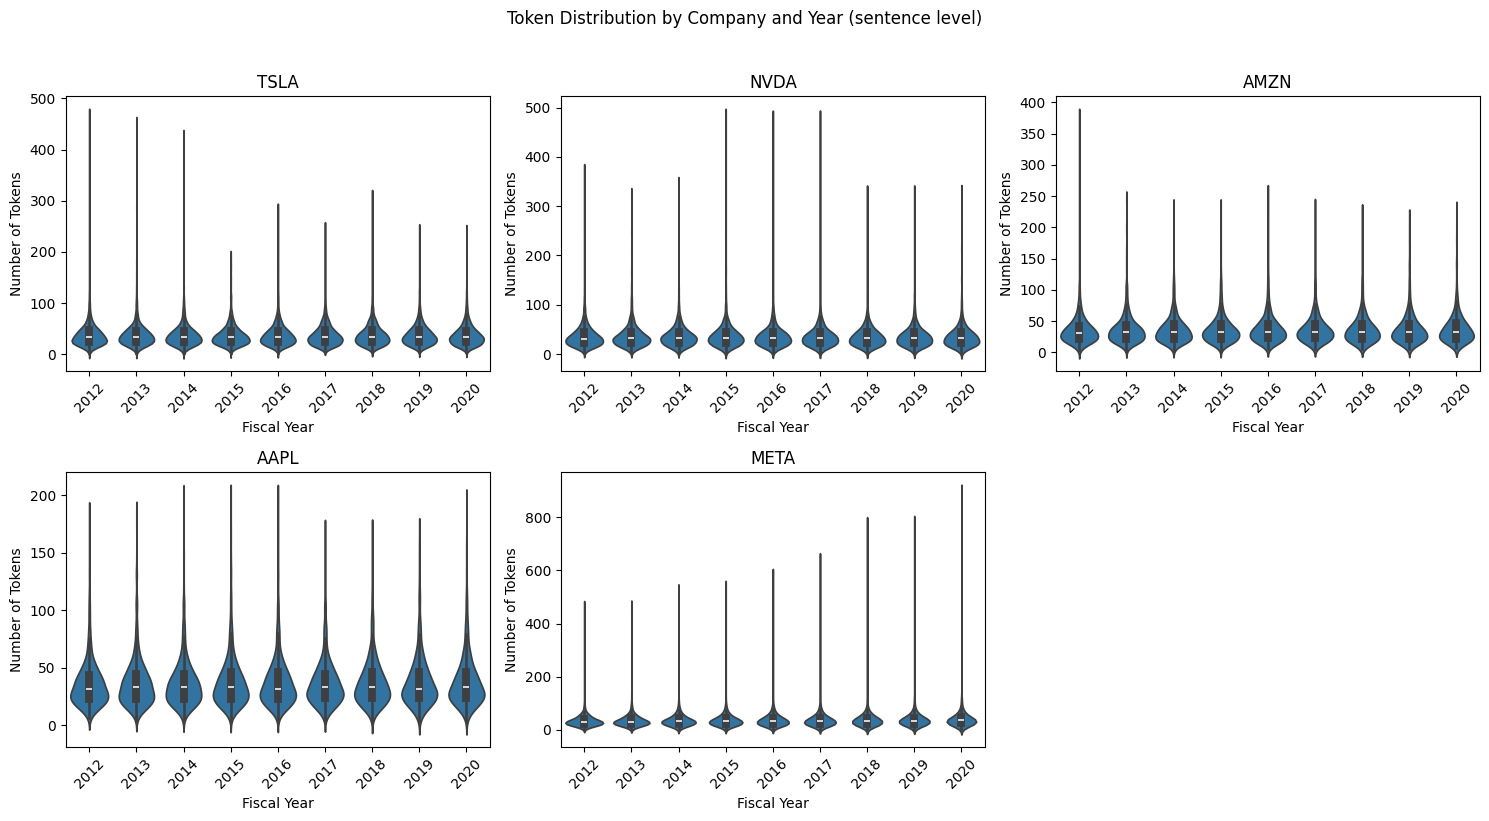

In [9]:
plot_token_distribution(df, token_col='sentence_token_count', title='Token Distribution by Company and Year (sentence level)')

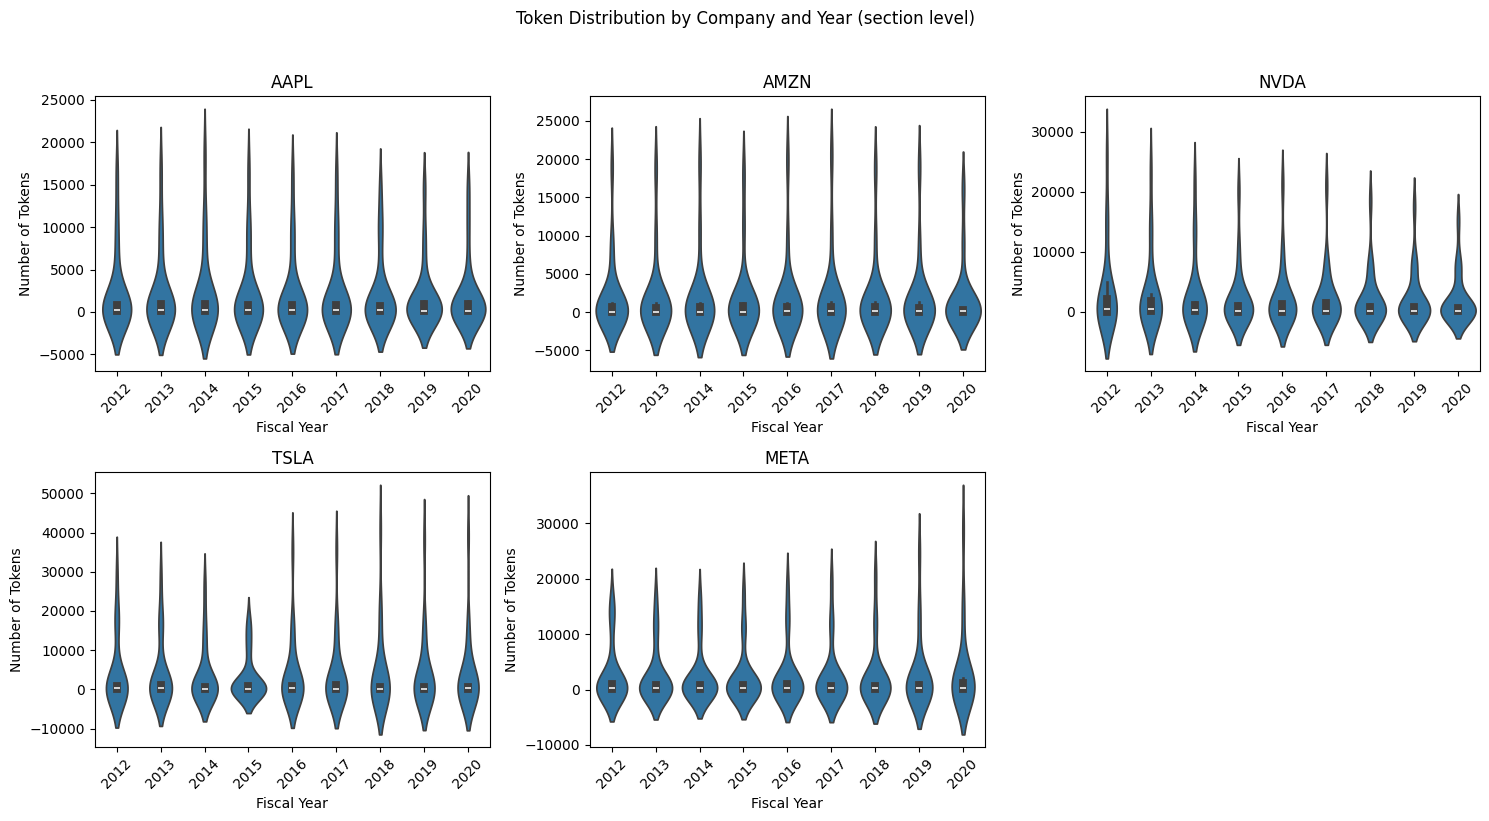

In [11]:


# Group by docID and section, sort by sentence_num, and concatenate sentences
df_docs = (df.sort_values(['docID', 'section', 'sentence_num'])
          .groupby(['docID', 'ticker', 'fiscal_year', 'section', 'section_num', 'section_letter'])
          .agg({'sentence': ' '.join})
          .reset_index()
          .rename(columns={'sentence': 'section_text'}))

df_docs['num_tokens'] = df_docs['section_text'].apply(count_tokens)
plot_token_distribution(df_docs, title='Token Distribution by Company and Year (section level)')

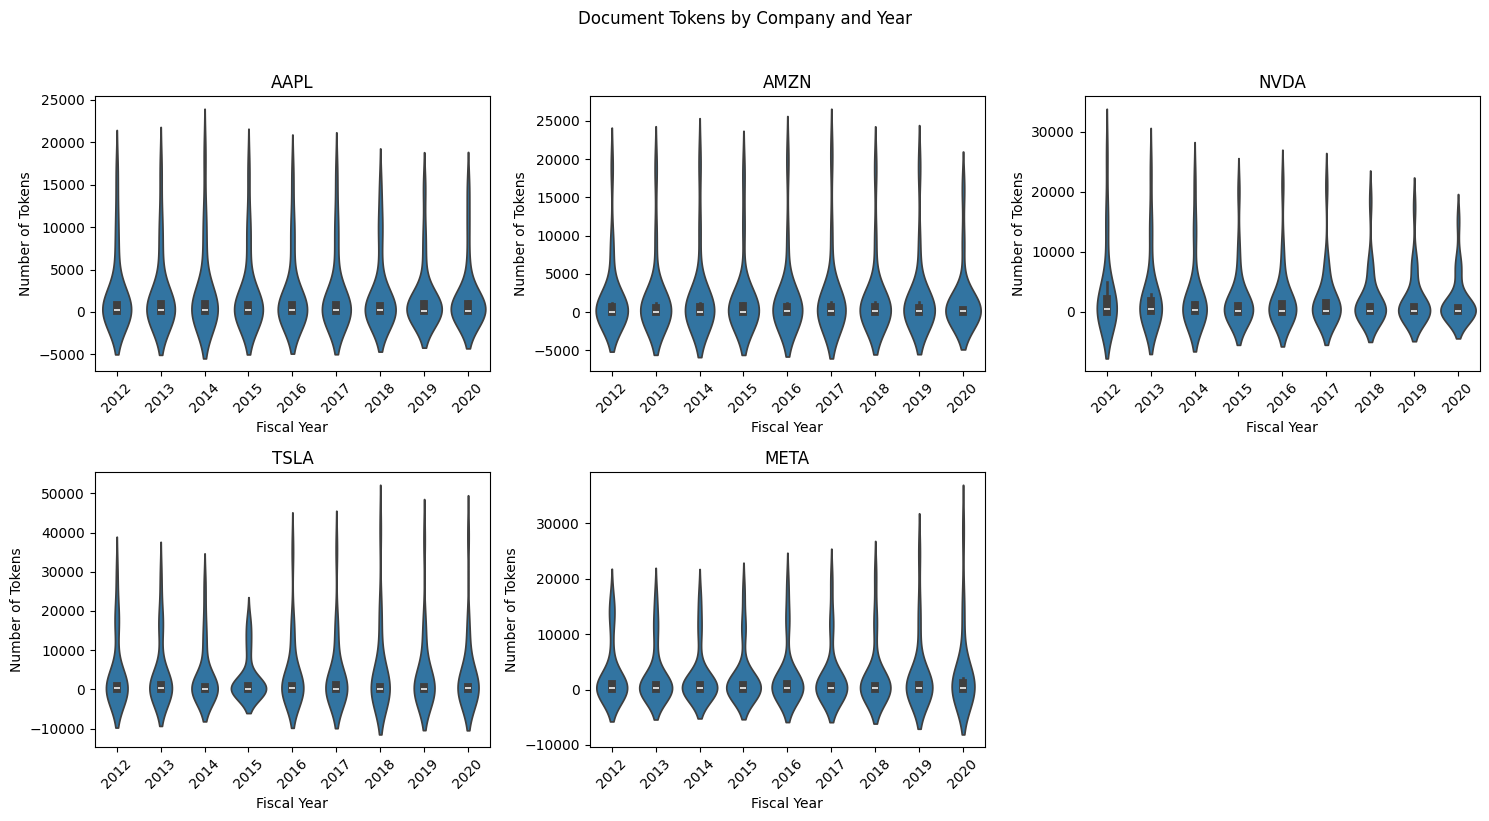

In [12]:


plot_token_distribution(
    df_docs, 
    token_col='num_tokens', 
    log_scale=False,
    title="Document Tokens by Company and Year")

OK so we have some very long sections. Most are between 0-5k tokens with a long tail up to 50k. So, we're going to have to do some pretty significant chunking. 

Documents are usually under 10k tokens. 

Sentences are usually under 100. 

- Target chunk size: 350 tokens. This is pretty standard and should get us a couple of sentences to work with, and if RAG retrieval is good then we might only need that much.
- Overlap: 50 tokens
- Hard ceiling: 800, it seems like there aren't any higher than that. 

## Chunking size

Our chunking strategy will be simple:
- Set target tokens (350 for now). We're cutting off at the sentence level. 
- 50 token overlap between chunks for semantic continuity
- Set a hard ceiling of 800 tokens. If we have some *very* long sentences, and it's not possible to keep them close to 350 tokens, then we'll cut the chunk off mid-sentence and continue with the next chunk. 

We'll also include metadata in all the chunk objects, including:
- Fiscal year
- A human readable ID for debugging
- Section number
- Section description
- Section letter
- Ticker

We can use this metadata to match keywords to the query if available, and exclude chunks in the vector DB that don't include those parameters. 

In [13]:
from src.sec_insights.rag.chunkers import SmartChunker
import pickle
target_tokens = 350
hard_ceiling = 800
overlap_tokens = 50

data_path = Path(os.getcwd()).parent / 'data'
embedding_pkl_path = data_path / 'cache' / 'embeddings' /f'chunks_{target_tokens}_{hard_ceiling}_{overlap_tokens}.pkl'

if embedding_pkl_path.exists():
    with open(embedding_pkl_path, 'rb') as f:
        chunks = pickle.load(f)
        print(f"✅ Loaded {len(chunks)} chunks from {embedding_pkl_path}")
else:
    chunker = SmartChunker(target_tokens=target_tokens, hard_ceiling=hard_ceiling, overlap_tokens=overlap_tokens)
    chunks = chunker.run(df)
    with open(embedding_pkl_path, 'wb') as f:
        pickle.dump(chunks, f)
    print(f"✅ Saved {len(chunks)} chunks to {embedding_pkl_path}")

print("Example chunk:")
pprint(chunks[0])


✅ Loaded 7837 chunks from /Users/jon/GitHub/dowjones-takehome/data/cache/embeddings/chunks_350_800_50.pkl
Example chunk:
Chunk(id='baf67bd9-9742-5521-80f2-f44d086c4c6c',
      text='Item 1. Business Company Background The Company designs, '
           'manufactures and markets mobile communication and media devices, '
           'personal computers, and portable digital music players, and sells '
           'a variety of related software, services, peripherals, networking '
           'solutions, and third-party digital content and applications. The '
           'Company’s products and services include iPhone®, iPad®, Mac®, '
           'iPod®, Apple TV®, a portfolio of consumer and professional '
           'software applications, the iOS and OS X® operating systems, '
           'iCloud®, and a variety of accessory, service and support '
           'offerings. The Company also sells and delivers digital content and '
           'applications through the iTunes Store®, App StoreSM, iB

## Embedding generation and analysis

For simplicity, we'll get Open AI's embeddings. There are better transformer models for this domain, and usually I would prefer to use a fine-tuned text embedding model that's been trained mostly on a corpus of financial texts, but many don't have API's. To avoid GPU cloud cost, I'll use OpenAI embeddings instead of alternatives, best option being `jina-embeddings-v3` which is trained for long form QA retrieval tasks. 

In production I assume we'll use our own embedding model hosted on our own infra, so I won't calculate this cost into the final savings. 

In [14]:
# add embeddings to chunks using openai
import openai
import torch
from tqdm import tqdm

from src.sec_insights.rag.config import VectorStoreConfig

if embedding_pkl_path.exists() and chunks[0].embedding is not None:
    with open(embedding_pkl_path, 'rb') as f:
        chunks = pickle.load(f)
        print(f"✅ Loaded {len(chunks)} chunks from {embedding_pkl_path}")
else:
    print("No embeddings found, generating new embeddings")    
    # Initialize OpenAI client
    client = openai.OpenAI()
    model = VectorStoreConfig.model
    dim = VectorStoreConfig.dim

    # Extract all text from chunks
    texts = [chunk.text for chunk in chunks]

    # Get embeddings in batches to avoid rate limits
    batch_size = 100
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Getting embeddings"):
        batch_texts = texts[i:i + batch_size]
        
        response = client.embeddings.create(
            model=model,
            input=batch_texts
        )
        
        # Extract embeddings and convert to torch tensors, ensuring 1536 dimensions
        batch_embeddings = []
        for emb in response.data:
            embedding_tensor = torch.tensor(emb.embedding, dtype=torch.float32)
            # Pad to 1536 dimensions if needed
            if embedding_tensor.shape[0] < dim:
                padding = torch.zeros(dim - embedding_tensor.shape[0], dtype=torch.float32)
                embedding_tensor = torch.cat([embedding_tensor, padding])
            batch_embeddings.append(embedding_tensor)
        
        embeddings.extend(batch_embeddings)

    # Assign embeddings to chunks
    for chunk, embedding in tqdm(zip(chunks, embeddings), desc="Assigning embeddings to chunks", total=len(chunks)):
        chunk.embedding = embedding

    with open(embedding_pkl_path, 'wb') as f:
        pickle.dump(chunks, f)

    print(f"✅ Added embeddings to {len(chunks)} chunks")

✅ Loaded 7837 chunks from /Users/jon/GitHub/dowjones-takehome/data/cache/embeddings/chunks_350_800_50.pkl


In [15]:
import pandas as pd
import plotly.express as px
from umap import UMAP



df_embeddings = pd.DataFrame(
    {
    'embedding': [chunk.embedding for chunk in chunks],
    'company': [chunk.metadata['ticker'] for chunk in chunks],
    'year': [chunk.metadata['fiscal_year'] for chunk in chunks],
    'section_num': [int(str(chunk.metadata['section_num'])) for chunk in chunks],
    'section': [chunk.metadata['section'] + chunk.metadata['section_letter'] for chunk in chunks],
    'section_desc': [chunk.metadata['section_desc'] for chunk in chunks],
    }
)

# Step 2: Reduce to 2D
reducer = UMAP()
df_embeddings['x'], df_embeddings['y'] = zip(*reducer.fit_transform(list(df_embeddings['embedding'])))

# Step 3: Visualize
fig1 = px.scatter(df_embeddings, x='x', y='y', color='year', hover_data=['company'], title='Embeddings by Year')
fig1.update_layout(
    # width=1500,
    height=750,
)
fig1.show()

fig2 = px.scatter(df_embeddings, x='x', y='y', color='company', hover_data=['section'], title='Embeddings by Company')
fig2.update_layout(
    # width=1500,
    height=750,
)
fig2.show()

fig3 = px.scatter(df_embeddings, x='x', y='y', color='section_desc', hover_data=['company'], title='Embeddings by Document Section')
fig3.update_layout(
    # width=1500,
    height=750,
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5)
)
fig3.show()


/Users/jon/GitHub/dowjones-takehome/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Key takeaways:
- 10K sections seem to be clustered together, showing that the embedding model is capturing the semantic similarities between them regardless of the company
- No clear difference in semantics throughout time
- TSLA 10K filings seem to be clustered together distinct from other companies, but NVDA META and AAPL have more overlap. This clustering isn't strong, though. 
- There are some outliers, which often seem to come from less frequently seen sections, or supplementary data (miscellaneous facts that didn't fit elsewhere in the document). This all makes sense. 

Overall the embedding model seems to be capturing semantic similarity the way we should. No clear evidence to change models from OpenAI just yet. 

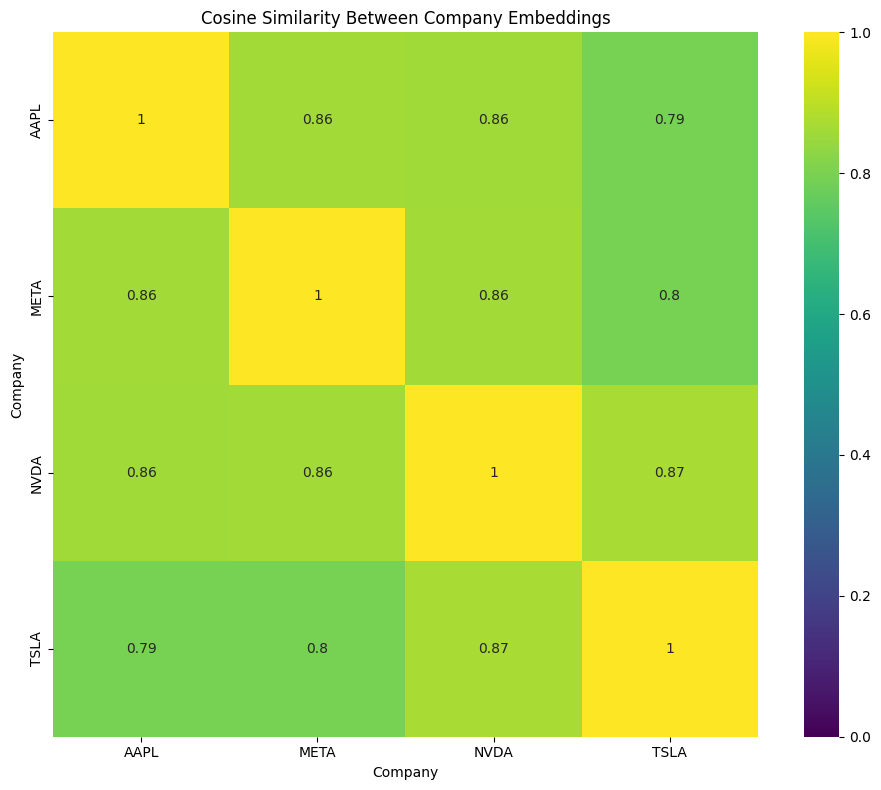

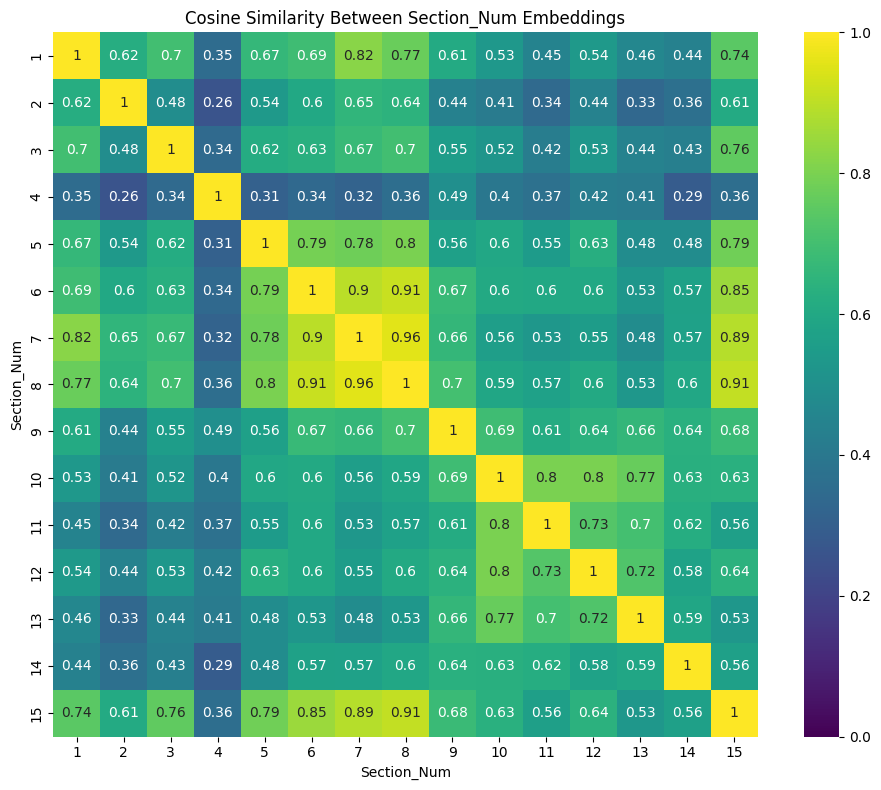

In [16]:
from src.sec_insights.eda.viz import plot_embedding_similarity
    
# Example usage:
plot_embedding_similarity(df_embeddings, dimension='company')
plot_embedding_similarity(df_embeddings, dimension='section_num')


Sections 6-8 have high similarity between each other. We could probably set some logic that if a question is likely about something in section 6, we'll weight sections 7 and 8 higher in the retrieval process. 

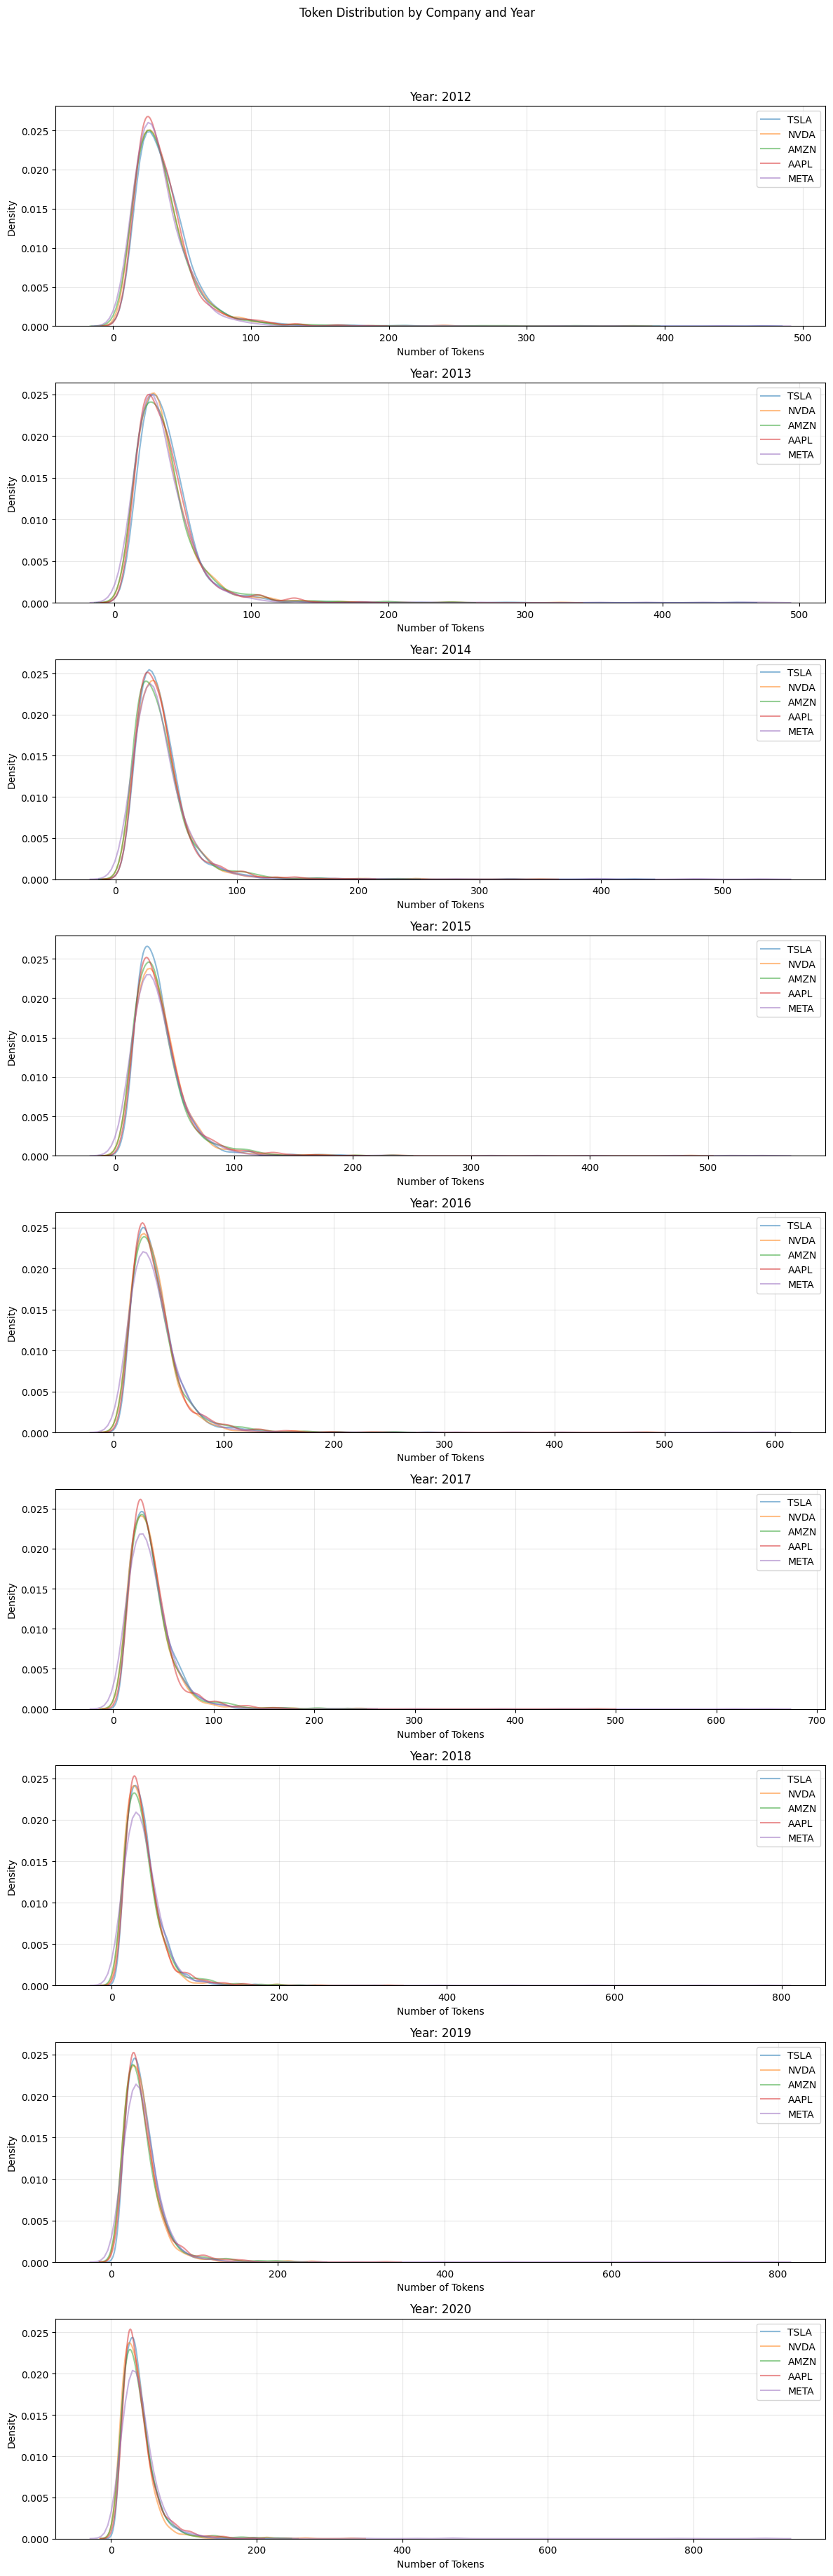

In [17]:
import seaborn as sns

years = sorted(df['fiscal_year'].unique())

# Create subplots for each year
fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)))
fig.suptitle('Token Distribution by Company and Year', y=1.02)

# Plot distribution for each year
for idx, year in enumerate(years):
    year_data = df[df['fiscal_year'] == year]
    
    # Plot distribution for each company in this year
    for ticker in year_data['ticker'].unique():
        data = year_data[year_data['ticker'] == ticker]['sentence_token_count']
        sns.kdeplot(data=data, label=ticker, alpha=0.5, ax=axes[idx])
    
    axes[idx].set_title(f'Year: {year}')
    axes[idx].set_xlabel('Number of Tokens')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Token distribution per year is quite similar

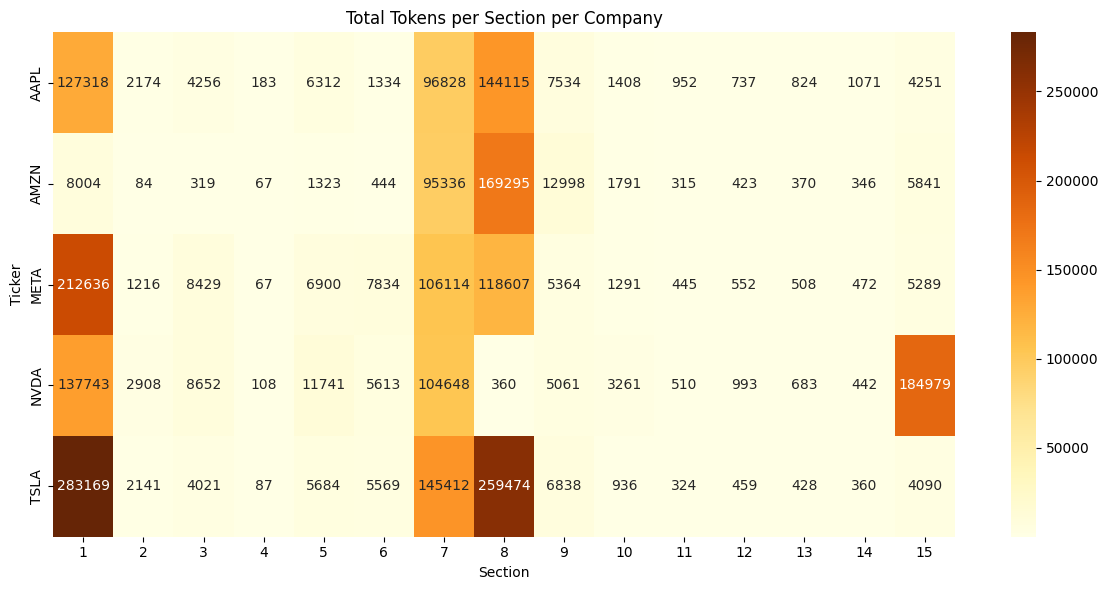

In [18]:
token_matrix = (
    df
    .groupby(["ticker", "section_num"])["sentence_token_count"]
    .sum()
    .unstack(fill_value=0)
)
plt.figure(figsize=(12, 6))
sns.heatmap(token_matrix, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Total Tokens per Section per Company")
plt.xlabel("Section")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()


Looks like there's some class imbalance we should normalize against. TSLA consistently has longer SEC filings, and we've seen that most of their tokens are in sections 8 and 1. 

Alright so this is what we see about the dataset:
- Sections are more or less equally represented amongst the companies. 
- Lengths of sections are not necessarily equally represented (e.g. NVDA has section 15s that are much longer than the other companies)
- META in general has many more long chunks than NVDA or TSLA. 

In order to make sure our evaluation set is unbiased, we'll do the following:
- **Stratify sampling across key dimensions**. We'll ensure balanced representation across company, year, section, and chunk class (short, medium, extra_large).
- **Downsample overrepresented long chunks**. Each company will contribute an equal number of long chunks to prevent verbosity from dominating QA coverage.
- **Limit QA pairs per group**. Each `(company, year, section, chunk_class)` group will be capped to a consistent number of QA pairs to enforce balance.


